# GATE: Sinogram, TOF, Random+Scatter Estimation

In [1]:
from __future__ import annotations
import torch
import pytomography
from pytomography.metadata import ObjectMeta, PETLMProjMeta, PETTOFMeta, PETSinogramPolygonProjMeta
from pytomography.projectors.PET import PETLMSystemMatrix, PETSinogramSystemMatrix
from pytomography.algorithms import OSEM
from pytomography.io.PET import gate, shared
from pytomography.likelihoods import PoissonLogLikelihood
import os
from pytomography.transforms.shared import GaussianFilter
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pytomography.io.PET import sss
from pytomography.io.PET.shared import sinogram_coordinates, sinogram_to_spatial
import gc

Required data:

In [2]:
path = '/disk1/pet_mri_scan/'
macro_path = os.path.join(path, 'mMR_Geometry.mac') 
info = gate.get_detector_info(path = macro_path,
    mean_interaction_depth=9, min_rsector_difference=0)
scanner_LUT = gate.get_scanner_LUT(info)
# Get detector IDs from GATE file
paths = [os.path.join(path, f'gate_simulation/all_physics/mMR_voxBrain_{i}.root') for i in range(1, 19)]
macro_path = os.path.join(path, 'mMR_Geometry.mac')

In [3]:
speed_of_light = 0.3 #mm/ps
fwhm_tof_resolution = 550 * speed_of_light / 2 #ps to position along LOR
TOF_range = 1000 * speed_of_light #ps to position along LOR (full range)
num_tof_bins = 5
tof_meta = PETTOFMeta(num_tof_bins, TOF_range, fwhm_tof_resolution, n_sigmas=3)

Before we delve into scatter/random modeling, lets get a baseline reconstruction that uses only primary events from the simulated GATE data. We can use PyTomography functionality to select for such events when we open the ROOT data. Obviously this is not doable for clinical data (where we don't know which events are randoms/scatters).

In [4]:
detector_ids = gate.get_detector_ids_from_root(
    paths,
    macro_path,
    tof_meta = tof_meta,
    include_randoms=False,
    include_scatters=False)
detector_ids = detector_ids[detector_ids[:,2]>-1] # For TOF, only take events within the TOF bins

Lets also get the true scatters and randoms from this data so we can compare our estimation:

In [5]:
detector_ids_randoms_true = gate.get_detector_ids_from_root(
    paths,
    macro_path,
    tof_meta=tof_meta,
    randoms_only=True)
detector_ids_scatters_true = gate.get_detector_ids_from_root(
    paths,
    macro_path,
    tof_meta=tof_meta,
    scatters_only=True)

Now we can reconstruct as we did in the introductory tutorials.

In [6]:
object_meta = ObjectMeta(
    dr=(2,2,2), #mm
    shape=(128,128,96) #voxels
)
norm_sinogram = torch.load(os.path.join(path, 'norm_sinogram.pt')) # assumes this has been saved from the intro tutorial
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta).to(pytomography.device)
proj_meta = PETSinogramPolygonProjMeta(info, tof_meta=tof_meta)
psf_transform = GaussianFilter(4) # 2mm gaussian blurring
system_matrix = PETSinogramSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       norm_sinogram = norm_sinogram,
       N_splits=10,
       attenuation_map=atten_map,
       device='cpu' # projections output on cpu, rest is GPU
)
sinogram = gate.listmode_to_sinogram(detector_ids, info, tof_meta=tof_meta)
likelihood = PoissonLogLikelihood(
    system_matrix,
    sinogram,
)
recon_algorithm = OSEM(likelihood)
recon_primaryonly = recon_algorithm(n_iters=2, n_subsets=24)
del(sinogram) # delete to save memory
del(system_matrix) 
del(likelihood)
del(recon_algorithm) 
gc.collect()

4310

And plot:

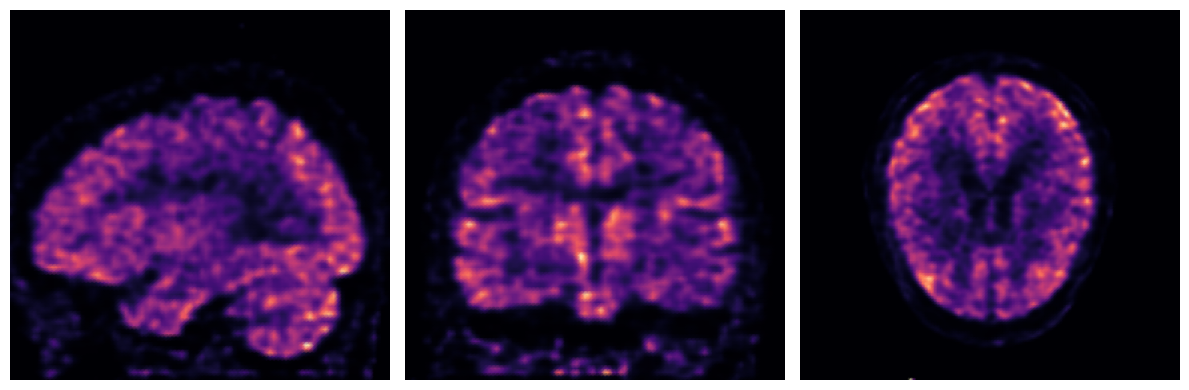

In [7]:
vmax = 0.05
fig, ax = plt.subplots(1,3,figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(recon_primaryonly[0,48,16:-16].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(recon_primaryonly[0,16:-16,64].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(recon_primaryonly[0,:,:,48].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.show()

Note that this is not possible in clinical practice, since we don't know which events are scatters/randoms. The reconstruction above is going to be used as an "ideal" comparison for our reconstruction of all events.

## Reconstruction Correcting For Randoms + Scatters

When time-of-flight information is used, estimation of randoms and scatters slightly changes. Lets first set up the system matrix for reconstruction

In [8]:
# All events
detector_ids = gate.get_detector_ids_from_root(
    paths,
    macro_path,
    tof_meta = tof_meta)
detector_ids = detector_ids[detector_ids[:,2]>-1] # For TOF, only take events within the TOF bins
sinogram = gate.listmode_to_sinogram(detector_ids, info, tof_meta=tof_meta)
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta)
norm_sinogram = torch.load(os.path.join(path, 'norm_sinogram.pt')) # assumes this has been saved from the intro tutorial
proj_meta = PETSinogramPolygonProjMeta(info, tof_meta=tof_meta)
psf_transform = GaussianFilter(4)
system_matrix = PETSinogramSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       norm_sinogram = norm_sinogram,
       N_splits=10,
       attenuation_map=atten_map,
       device='cpu' # projections output on cpu, rest is GPU
)

### Randoms

In addition to the first two steps of the non-TOF procedure (obtaining a random sinogram and smoothing), we now also need to account for the fact that the number of randoms in each TOF bin is proportional to the length of the TOF bin divided by the total coincidence timing width. We can do this using the `randoms_sinogram_to_sinogramTOF` function. We need to provide the `tof_meta`

In [9]:
detector_ids_randoms = gate.get_detector_ids_from_root(
    paths,
    macro_path,
    substr = 'delay')
# Load random events accross all TOF bins
sinogram_random = gate.listmode_to_sinogram(detector_ids_randoms, info)
sinogram_random = gate.smooth_randoms_sinogram(sinogram_random, info, sigma_r=4, sigma_theta=4, sigma_z=4)
sinogram_random = gate.randoms_sinogram_to_sinogramTOF(sinogram_random, tof_meta, coincidence_timing_width = 4300)

### Scatters

Like before, lets first get an initial reconstruction without scatter.

In [10]:
additive_term = sinogram_random / system_matrix.compute_sensitivity_sinogram().cpu()
likelihood = PoissonLogLikelihood(
        system_matrix,
        sinogram,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_without_scatter_estimation = recon_algorithm(2,24)

There are two additional parameters we need to provide to the function:

1. `tof_meta`: Provides all the required TOF metadata
2. `num_dense_tof_bins`: The emission integrals in Watson [CITE] are split into multiple regions: this specifies the number of regions. This is independent and seperate from any of the information in `tof_meta`.

**Note: this takes ~10 minutes to run**

In [11]:
sinogram_scatter = sss.get_sss_scatter_estimate(
    object_meta = object_meta,
    proj_meta = proj_meta,
    pet_image = recon_without_scatter_estimation,
    attenuation_image = atten_map,
    system_matrix = system_matrix,
    proj_data = sinogram,
    image_stepsize = 4,
    attenuation_cutoff = 0.004,
    sinogram_interring_stepsize = 4,
    sinogram_intraring_stepsize = 4,
    sinogram_random = sinogram_random,
    tof_meta = tof_meta,
    num_dense_tof_bins = 25
    )

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


This TOF sinogram can be compared to the true scatter in each TOF bin. We'll look at summed profiles like we did above.

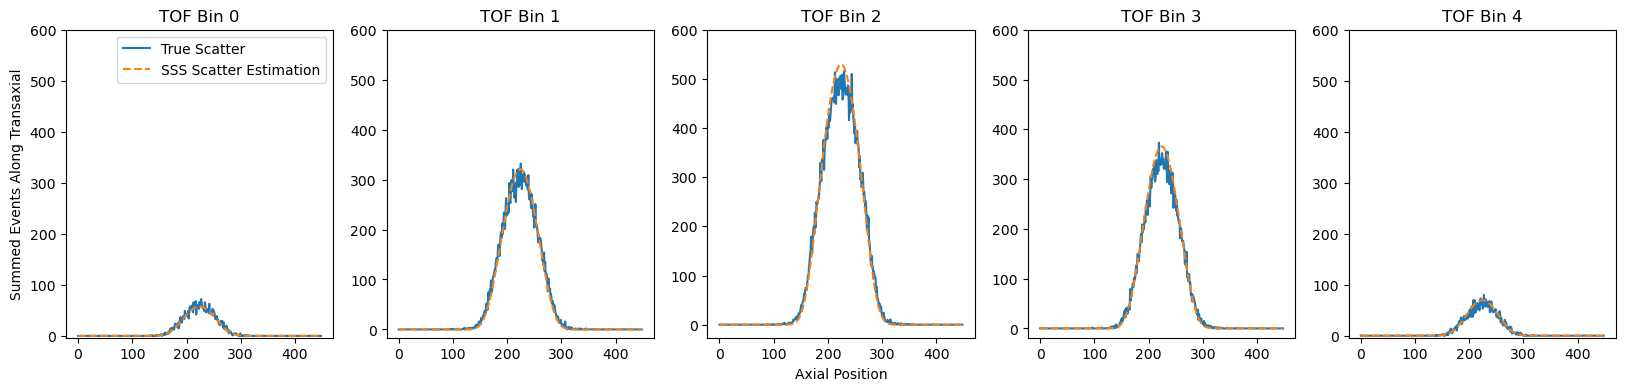

In [12]:
sinogram_scatters_true = gate.listmode_to_sinogram(detector_ids_scatters_true, info, tof_meta=tof_meta)

fig, ax = plt.subplots(1,5,figsize=(20,4))
# loop TOF bins
for i in range(5):
    ax[i].plot(sinogram_scatters_true[:,:,:64,i].sum(dim=(0,2)), label='True Scatter')
    ax[i].plot(sinogram_scatter[:,:,:64,i].sum(dim=(0,2)), ls='--', label='SSS Scatter Estimation')
    ax[i].set_title(f'TOF Bin {i}')
    ax[i].set_ylim(top=600)
ax[0].legend()
ax[2].set_xlabel('Axial Position')
ax[0].set_ylabel('Summed Events Along Transaxial')
plt.show()

From the estimated scatter sinogram we can then reconstruct:

In [13]:
additive_term = (sinogram_random + sinogram_scatter) / system_matrix.compute_sensitivity_sinogram().cpu()
likelihood = PoissonLogLikelihood(
        system_matrix,
        sinogram,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_sinogram_TOF = recon_algorithm(2,24)

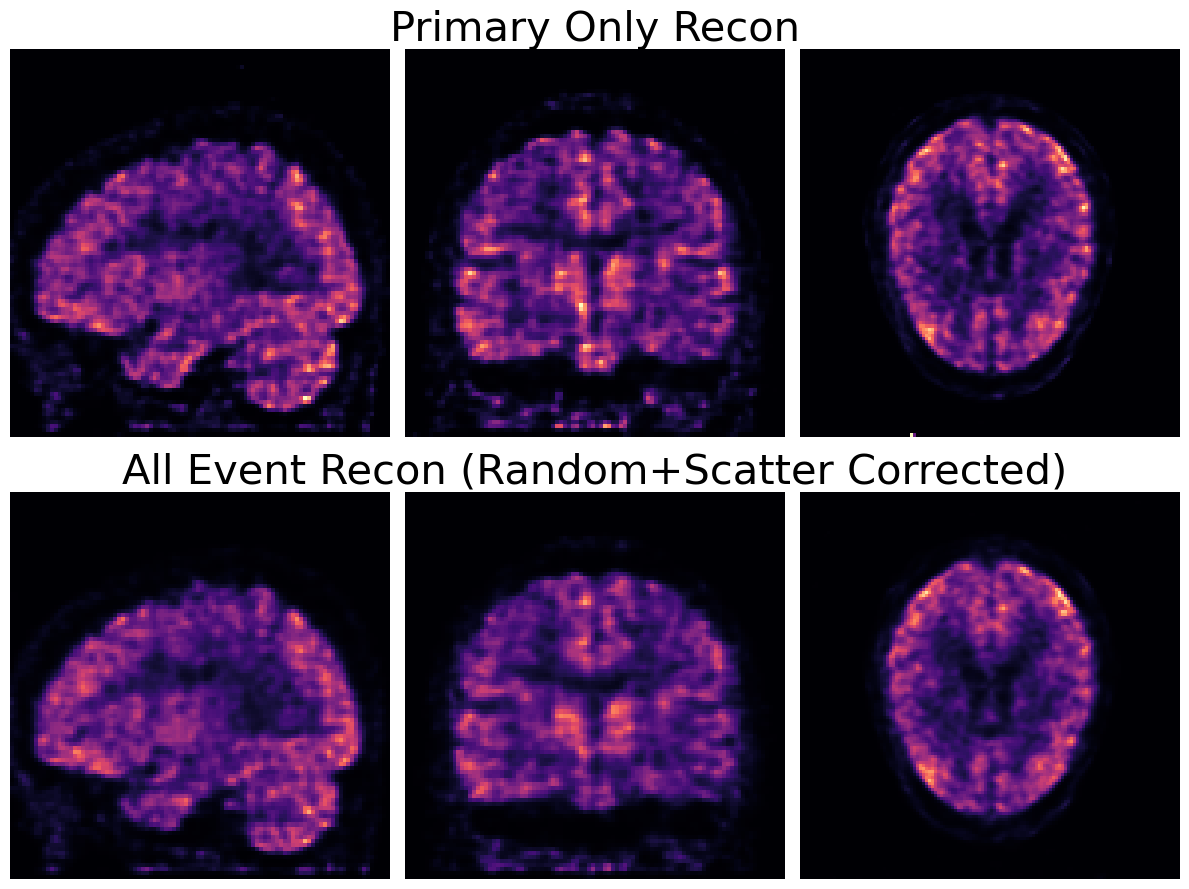

In [14]:
vmax = 0.05
fig, ax = plt.subplots(2,3,figsize=(12,9))
plt.subplot(231)
plt.pcolormesh(recon_primaryonly[0,48,16:-16].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.subplot(232)
plt.pcolormesh(recon_primaryonly[0,16:-16,64].cpu().T, cmap='magma', vmax=vmax)
plt.title('Primary Only Recon', fontsize=30)
plt.axis('off')
plt.subplot(233)
plt.pcolormesh(recon_primaryonly[0,:,:,48].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.subplot(234)
plt.pcolormesh(recon_sinogram_TOF[0,48,16:-16].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.subplot(235)
plt.pcolormesh(recon_sinogram_TOF[0,16:-16,64].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.title('All Event Recon (Random+Scatter Corrected)', fontsize=30)
plt.subplot(236)
plt.pcolormesh(recon_sinogram_TOF[0,:,:,48].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.show()